In [91]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Subset

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

# GPU check

In [92]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Data inspection

In [115]:
# Transformation
transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(p=.5),
    T.Normalize(.5,.5)
])

#import data and apply transformation
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
dev_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# split devset into multiple sets for dev and test
rand_indexc = np.random.permutation(10000)
test_set =Subset(dev_set,rand_indexc[:5000])
val_set =Subset(dev_set,rand_indexc[5000:])

# Translate into dataloader objects
batch_sz = 32
train_loader = DataLoader(train_set,batch_size=batch_sz, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=len(test_set))
val_loader = DataLoader(val_set,batch_size=len(val_set))

In [116]:
# Dataset inspection
print('Data shapes (train/test/val):')
print(len(train_set))
print(len(test_set))
print(len(val_set))

# Pixel density value range
print('\nData value range: ')
print( (torch.min(train_set.data),torch.max(train_set.data)) )

#unique categories
print('\nData categories: ')
print(train_set.classes)

Data shapes (train/test/val):
60000
5000
5000

Data value range: 
(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

Data categories: 
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [117]:
# Pixel density value range after transformation
print('\nData value range when transformation is applied ')
X,y = next(iter(test_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )


Data value range when transformation is applied 
Data shapes (train/test):
torch.Size([5000, 1, 28, 28])

Data value range:
(tensor(-1.), tensor(1.))


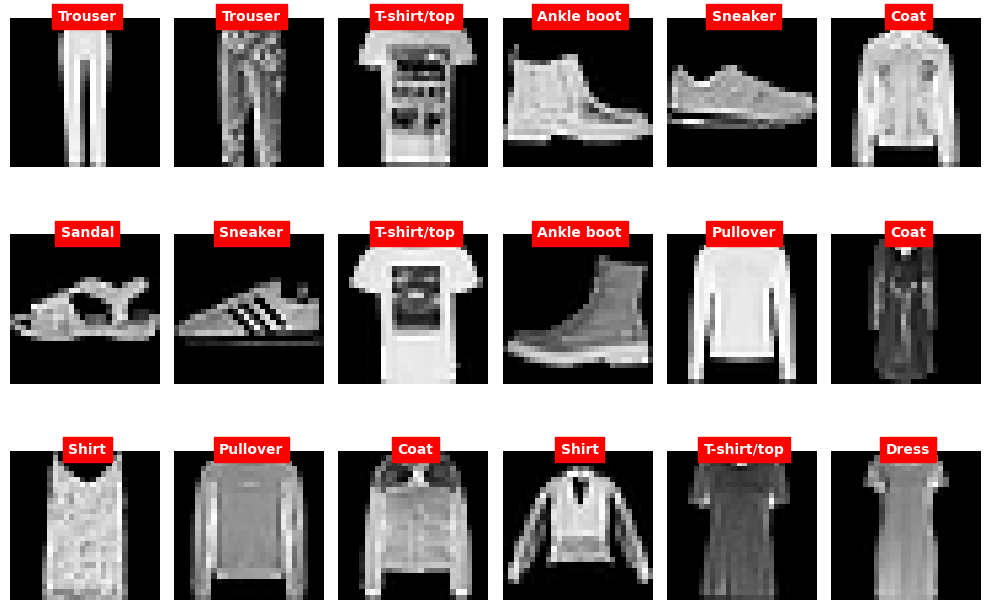

In [118]:
# Visualizing some random images
#ps. Matplotlib doesn't support negative values so negative values would be auto clipped

fig,axs = plt.subplots(3,6,figsize=(10,7),dpi=100)

for (i,ax) in enumerate(axs.flatten()):

    #extract image
    pic = torch.squeeze(X.data[i])
    pic = pic/2+.5 #undo normalization

    # and the label
    label = train_set.classes[y[i]]

    #visualize
    ax.imshow(pic,cmap='gray')
    ax.text(14,0,label,ha='center',fontweight='bold',color='w',backgroundcolor='r')
    ax.axis('off')


plt.tight_layout()
plt.show()

# Create the DL Model

In [138]:
# create a class for the model
def make_the_net(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)
      # (law: (inputsize + 2 x padding - kernel size)/stride + 1 = ouput size) ,/2 for pool window

      # second convolution layer
      self.conv2  = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3)
      self.bnorm2 = nn.BatchNorm2d(32) # input the number of channels in this layer
      # output size: (14+2*0-3)/1 + 1 = 12/2 = 6 (/2 b/c maxpool)

      #3rd convolution layer
      self.conv3 = nn.Conv2d(in_channels=32,out_channels=128,kernel_size=3,padding=1)
      self.bnorm3 = nn.BatchNorm2d(128)
      #output size: (6+2*1-3)/1+1 = 6/2 = 3

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(3*3*128,64)
      self.fc2 = nn.Linear(64,32)
      self.fc3 = nn.Linear(32,10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # 3rd block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training) # training=self.training means to turn off during eval mode
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Sanity test

In [139]:
# test the model with one batch
net,lossfun,optimizer = make_the_net()

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3366, grad_fn=<NllLossBackward0>)


# Create a function for training the model

In [140]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 20

  # create a new model
  net,lossfun,optimizer = make_the_net()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance
    net.eval() # switch to test mode
    X,y = next(iter(test_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

    # and get average losses and accuracies across the batches
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

# Run the model and observe results

In [141]:
# ~3 minutes with 10 epochs on GPU
trainLoss,testloss,trainAcc,testacc,net = funtion2trainTheModel()

In [142]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(val_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
val_loss = loss.item()
val_acc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

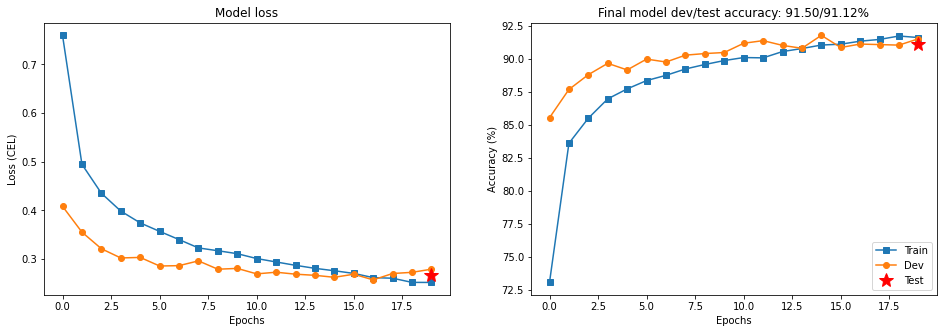

In [143]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testloss,'o-',label='Dev')
ax[0].plot(len(testloss)-1,val_loss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testacc,'o-',label='Dev')
ax[1].plot(len(testacc)-1,val_acc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {testacc[-1]:.2f}/{val_acc:.2f}%')
ax[1].legend()

plt.show()

In [144]:
from torchsummary import summary

In [145]:
summary(net,(1,28,28),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
            Conv2d-3           [-1, 32, 12, 12]           4,640
       BatchNorm2d-4             [-1, 32, 6, 6]              64
            Conv2d-5            [-1, 128, 6, 6]          36,992
       BatchNorm2d-6            [-1, 128, 3, 3]             256
            Linear-7                   [-1, 64]          73,792
            Linear-8                   [-1, 32]           2,080
            Linear-9                   [-1, 10]             330
Total params: 118,346
Trainable params: 118,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.45
Estimated Total Size (MB): 0.66
-------------------------------------------

# The end
I have got around 91.10% accuracy with my network architecture